## Business Understanding

## Data Understanding

In [97]:
from IPython.display import display
from IPython.display import Image
import pydotplus
from sklearn.externals.six import StringIO 
from subprocess import call
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report 
from deslib.static.stacked import StackedClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

In [2]:
pd.set_option('display.max_columns',999)

In [3]:
df = pd.read_csv("covtype.csv")

In [4]:
df= df.apply(lambda x: x.sample(n=100000, replace = True, random_state = 1))

In [5]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
128037,2771,27,11,0,0,1880,215,217,137,2089,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491755,2889,64,9,218,84,685,229,221,125,930,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
470924,3095,84,7,0,0,1167,230,228,131,2140,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
491263,3075,140,14,240,-6,866,240,235,122,1237,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
371403,3288,353,13,417,77,3439,196,216,157,2698,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [6]:
df.reset_index(drop=True,inplace=True)

In [7]:
df.shape

(100000, 55)

In [8]:
df.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,100000.000000,100000.000000,100000.00000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,2960.503820,156.034500,14.09028,269.46504,46.577100,2356.821130,212.102240,223.450730,142.731840,1976.750600,0.448260,0.052070,0.436820,0.062850,0.005110,0.013210,0.008190,0.021030,0.002830,0.011460,0.0001,0.000230,0.001970,0.055920,0.020920,0.050340,0.030820,0.000870,0.0,0.005110,0.005940,0.003470,0.007140,0.015920,0.001420,0.058280,0.099710,0.035690,0.000870,0.004490,0.001990,0.001630,0.198840,0.051700,0.044320,0.09191,0.077430,0.002620,0.003300,0.00021,0.000460,0.025740,0.023680,0.015130,2.043550
std,279.781093,111.834835,7.49341,211.79849,58.301387,1559.597647,26.723596,19.748727,38.306991,1317.725934,0.497318,0.222169,0.495995,0.242694,0.071302,0.114174,0.090128,0.143485,0.053123,0.106437,0.0100,0.015164,0.044341,0.229768,0.143117,0.218647,0.172831,0.029483,0.0,0.071302,0.076843,0.058805,0.084197,0.125167,0.037656,0.234273,0.299614,0.185517,0.029483,0.066857,0.044565,0.040341,0.399129,0.221422,0.205806,0.28890,0.267274,0.051119,0.057351,0.01449,0.021443,0.158359,0.152051,0.122071,1.387045
min,1866.000000,0.000000,0.00000,0.00000,-163.000000,0.000000,0.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2811.000000,59.000000,9.00000,108.00000,7.000000,1110.000000,198.000000,213.000000,119.000000,1022.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2998.000000,128.000000,13.00000,218.00000,30.000000,2010.000000,218.000000,226.000000,143.000000,1710.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           100000 non-null  int64
 1   Aspect                              100000 non-null  int64
 2   Slope                               100000 non-null  int64
 3   Horizontal_Distance_To_Hydrology    100000 non-null  int64
 4   Vertical_Distance_To_Hydrology      100000 non-null  int64
 5   Horizontal_Distance_To_Roadways     100000 non-null  int64
 6   Hillshade_9am                       100000 non-null  int64
 7   Hillshade_Noon                      100000 non-null  int64
 8   Hillshade_3pm                       100000 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  100000 non-null  int64
 10  Wilderness_Area1                    100000 non-null  int64
 11  Wilderness_Area2                    100000 non-null  

In [10]:
# df.hist(bins=20,figsize=(36,36))
# plt.show()

## Data Preparation

In [11]:
df['Pine'] = df.Cover_Type.apply(lambda x: 1 if x == 2 else 0)

In [12]:
df.drop(["Cover_Type"],axis=1,inplace=True)

In [13]:
cat_columns = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
               'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
               'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
               'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
               'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
               'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
               'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
               'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
               'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
               'Soil_Type39', 'Soil_Type40', 'Wilderness_Area1',
               'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4','Pine']

In [14]:
num_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
               'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
               'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
               'Horizontal_Distance_To_Fire_Points']

In [15]:
scaler = StandardScaler()

In [16]:
df_num_s = pd.DataFrame(scaler.fit_transform(df[num_columns]))

In [17]:
df_num_s.columns = df[num_columns].columns

In [18]:
df_plus_wild_s = pd.concat([df_num_s,df[cat_columns]],axis=1)

In [19]:
df_plus_wild_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Pine
0,-0.677332,-1.153801,-0.412402,-1.272277,-0.798906,-0.305735,0.108435,-0.326642,-0.149630,0.085185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,-0.255572,-0.822954,-0.679304,-0.242992,0.641890,-1.071962,0.632319,-0.124096,-0.462890,-0.794365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
2,0.480722,-0.644118,-0.946207,-1.272277,-0.798906,-0.762906,0.669740,0.230359,-0.306260,0.123888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0.409237,-0.143377,-0.012048,-0.139119,-0.901820,-0.955906,1.043943,0.584814,-0.541205,-0.561387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,1.170550,1.761227,-0.145499,0.696585,0.521824,0.693887,-0.602551,-0.377278,0.372471,0.547347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
df_s = df_plus_wild_s.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)

In [21]:
df_s.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Pine
0,-0.677332,-1.153801,-0.412402,-1.272277,-0.798906,-0.305735,0.108435,-0.326642,-0.149630,0.085185,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-0.255572,-0.822954,-0.679304,-0.242992,0.641890,-1.071962,0.632319,-0.124096,-0.462890,-0.794365,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0.480722,-0.644118,-0.946207,-1.272277,-0.798906,-0.762906,0.669740,0.230359,-0.306260,0.123888,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.409237,-0.143377,-0.012048,-0.139119,-0.901820,-0.955906,1.043943,0.584814,-0.541205,-0.561387,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,1.170550,1.761227,-0.145499,0.696585,0.521824,0.693887,-0.602551,-0.377278,0.372471,0.547347,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [22]:
X_plus_wild = df.drop('Pine',1)
X_plus_wild_s = df_s.drop('Pine',1)
X = X_plus_wild.drop(['Wilderness_Area1','Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4'],axis=1)
X_s = df_s.drop('Pine',1)

y = df["Pine"]

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25,random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=.25,random_state=42)


In [24]:
X_train_s, X_test_S, y_train, y_test = train_test_split(X_s,y,test_size=.25,random_state=42)

X_train_s, X_val_s, y_train, y_val = train_test_split(X_train_s,y_train,test_size=.25,random_state=42) 


In [25]:
X_plus_wild_train, X_plus_wild_test, y_train, y_test = train_test_split(X_plus_wild,y,test_size=.25,random_state=42)

X_plus_wild_train, X_plus_wild_val, y_train, y_val = train_test_split(X_plus_wild_train,y_train,test_size=.25,random_state=42)


In [26]:
X_plus_wild_train_s, X_plus_wild_test_s, y_train, y_test = train_test_split(X_plus_wild_s,y,test_size=.25,random_state=42)

X_plus_wild_train_s, X_plus_wild_val_s, y_train, y_val = train_test_split(X_plus_wild_train_s,y_train,test_size=.25,random_state=42)


## Modelling

In [27]:
skf = StratifiedKFold(n_splits=5,random_state=42)

In [135]:
#================================================================================================#

# Classification Models Class

#================================================================================================#

class Classification():
    def __init__(self,model_type,x_train,x_val,y_train,y_val):
        self.model_type = model_type
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.scores_table = pd.DataFrame()
        
        if self.model_type == 'Logistic Regression':
                self.technique = LogisticRegression(fit_intercept=False)
        elif self.model_type == 'Decision Tree':
                self.technique = DecisionTreeClassifier(random_state=42)
        elif self.model_type == 'Random Forest':
                self.technique = RandomForestClassifier(n_estimators=10,n_jobs=-1,random_state=42)
                
#================================================================================================#

# Score Function

#================================================================================================#

    def scores(self,model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]

        val_prob = model.predict_proba(X_val)[:,1]

        auc_train = roc_auc_score(y_train,train_prob)
        auc_val = roc_auc_score(y_val,val_prob)
        
        self.auc_train = auc_train
        self.auc_val = auc_val
        
        self.scores_table["Model Name"] = [self.model_type]
        self.scores_table["Train AUC"] = [self.auc_train]
        self.scores_table["Validation AUC"] = [self.auc_val]

        
        return self.scores_table
        
#================================================================================================#

# Threshold Annotation Function

#================================================================================================#

    def annot(fpr,tpr,thr):
        k=0
        for i,j in zip(fpr,tpr):
            if k %50 == 0:
                plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
            k+=1
        
#================================================================================================#

# ROC Plot Function

#================================================================================================#
     
    def roc_plot(model,X_train,X_val,y_train,y_val):
        train_prob = model.predict_proba(X_train)[:,1]
        val_prob = model.predict_proba(X_val)[:,1]
        plt.figure(figsize=(7,7))
        for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
            fpr, tpr, threshold = roc_curve(data[0], data[1])
            plt.plot(fpr, tpr)
        Classification.annot(fpr, tpr, threshold)
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.ylabel('TPR (power)')
        plt.xlabel('FPR (alpha)')
        plt.legend(['train','val'])
        plt.show()

#================================================================================================#

# Get Scores Function -> Outputs a DataFrame with optimum AUC scores and R^2 scores, and a ROC Plot

#================================================================================================#

    def get_scores(self,param_grid,cv_type):
        reg = self.technique
        fit_reg = reg.fit(self.x_train,self.y_train)
        opt_model = GridSearchCV(fit_reg,
                                 param_grid,
                                 cv=cv_type,
                                 scoring='roc_auc',
                                 return_train_score=True,
                                 n_jobs=-1)
        self.opt_model = opt_model.fit(self.x_train,self.y_train) 
        self.best_model = opt_model.best_estimator_
        self.scores = Classification.scores(self,self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.best_params = opt_model.best_params_
        display(self.scores_table)
        print("The best hyperparameters are: ", self.best_params,'\n')
        self.roc_plot = Classification.roc_plot(self.best_model,self.x_train,self.x_val,self.y_train,self.y_val)
        self.y_tested = opt_model.predict(self.x_val)

#================================================================================================#

# Optimum Plot Function

#================================================================================================#

    def opt_plots(self):
        if self.model_type == "Decision Tree" or self.model_type == "Random Forest":
            opt = pd.DataFrame(self.opt_model.cv_results_)
            cols = [col for col in opt.columns if ('mean' in col or 'std' in col) and 'time' not in col]
            params = pd.DataFrame(list(opt.params))
            opt = pd.concat([params,opt[cols]],axis=1,sort=False)

            plt.figure(figsize=[15,4])
            plt.subplot(121)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_train_score')*100)
            plt.title('ROC_AUC - Training')
            plt.subplot(122)
            sns.heatmap(pd.pivot_table(opt,index='max_depth',columns='min_samples_leaf',values='mean_test_score')*100)
            plt.title('ROC_AUC - Validation')
        else:
            print("This model does not have an optimum hyperparameter plot!")
        
#================================================================================================#

# Confusion Matrix Function

#================================================================================================#

    def conf_matrix(y_true, y_pred):
        cm = {'TP': 0, 'TN': 0, 'FP': 0, 'FN': 0}

        for ind, label in enumerate(y_true):
            pred = y_pred[ind]
            if label == 1: 
                if label == pred:
                    cm['TP'] += 1
                else:
                    cm['FN'] += 1
            else:
                if label == pred:
                    cm['TN'] += 1
                else:
                    cm['FP'] += 1

        return cm
    
#================================================================================================#

# Display Confusion Matrix Table Function

#================================================================================================#
    
    def show_conf_matrix(self):
        Classification.conf_matrix(self.y_val,self.y_tested)
        cnf_matrix = confusion_matrix(self.y_val,self.y_tested)

        plt.figure(figsize=(7,7))
        plt.imshow(cnf_matrix,  cmap=plt.cm.Blues) 

        plt.title('Confusion Matrix')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        class_names = set(y)
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
                plt.text(j, i, cnf_matrix[i, j],
                         horizontalalignment='center')
        plt.colorbar
        
#================================================================================================#

# Plot Decision Tree Function

#================================================================================================#

    def plot_decision_tree(self):
        if self.model_type == "Decision Tree":
            dot_data = StringIO()
            export_graphviz(self.best_model, out_file=dot_data,  
                            filled=True, rounded=True,
                            special_characters=True)
            graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
            
            graph.write_png(f'{self.model_type}.png')
            
            img = mpimg.imread(f'{self.model_type}.png')
            plt.figure(figsize=(40,50))
            plt.imshow(img)
            plt.show()
            
            
        
        else:
            print("This model does not have a decision tree plot!")
            
        

### Logistic Regression

In [47]:
logistic_plus_wild = Classification('Logistic Regression',X_plus_wild_train_s,X_plus_wild_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC,Train R^2,Validation R^2
0,Logistic Regression,0.800175,0.798317,0.730542,0.729707


The best hyperparameters are:  {} 



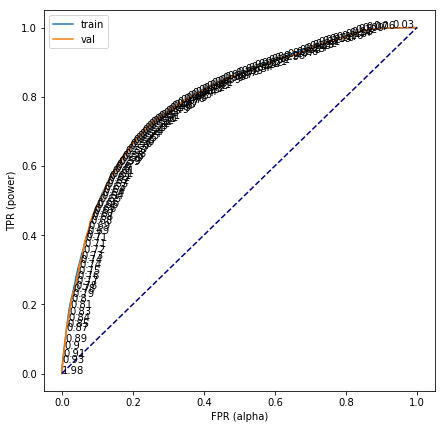

CPU times: user 5.56 s, sys: 485 ms, total: 6.04 s
Wall time: 11.7 s


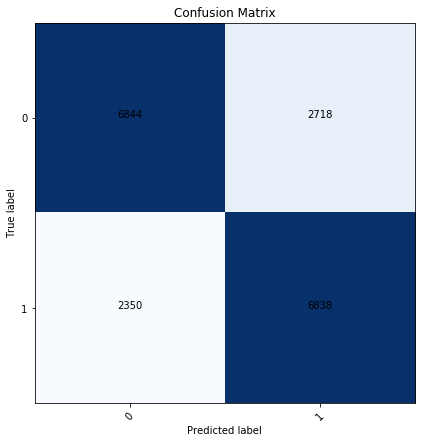

In [30]:
%%time

# param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties
#               "solver" : ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
#               "C":[0.320,0.325,0.330]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
param_grid = {}

logistic_plus_wild.get_scores(param_grid,skf)
logistic_plus_wild.show_conf_matrix()

In [31]:
logistic = Classification('Logistic Regression',X_train_s,X_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC,Train R^2,Validation R^2
0,Logistic Regression,0.800175,0.798317,0.730542,0.729707


The best hyperparameters are:  {} 



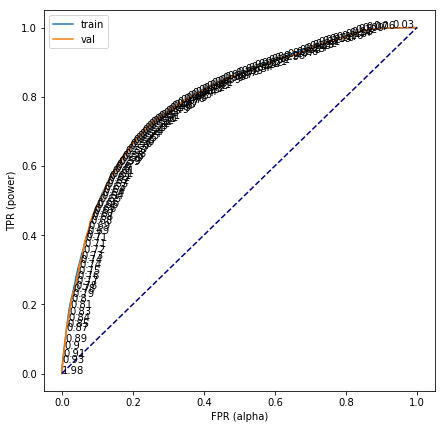

CPU times: user 5.42 s, sys: 447 ms, total: 5.87 s
Wall time: 7.34 s


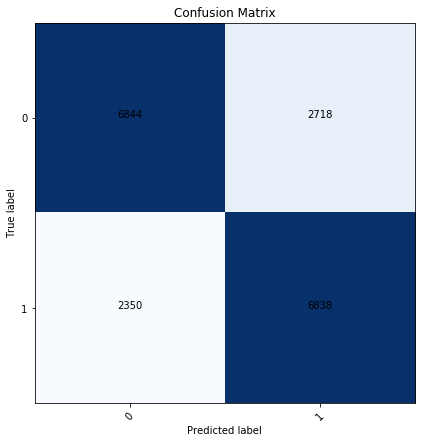

In [32]:
%%time

# param_grid = {"penalty":['l1', 'l2'],            # l1 and l2 are different type of penalties
#               "solver" : ['liblinear', 'saga'],  # Algorithm to use in the optimization problem
#               "C":[0.320,0.325,0.330]}           # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization
param_grid = {}

logistic.get_scores(param_grid,skf)
logistic.show_conf_matrix()

In [33]:
logistic.opt_plots()

This model does not have an optimum hyperparameter plot!


In [34]:
logistic.plot_decision_tree()

This model does not have a decision tree plot!


### Decision Tree

In [136]:
dtree_plus_wild = Classification('Decision Tree',X_plus_wild_train_s,X_plus_wild_val_s,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Decision Tree,0.813368,0.811141


The best hyperparameters are:  {'max_depth': 6, 'min_samples_leaf': 700} 



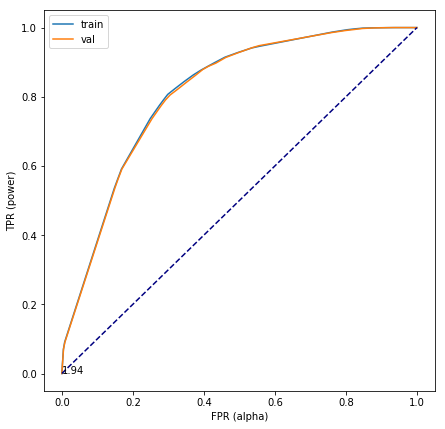

CPU times: user 3.12 s, sys: 326 ms, total: 3.44 s
Wall time: 12.8 s


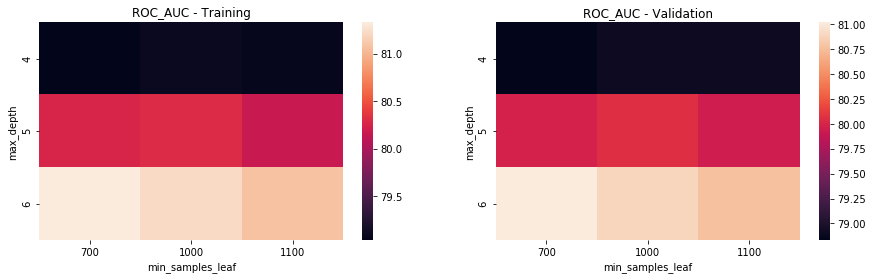

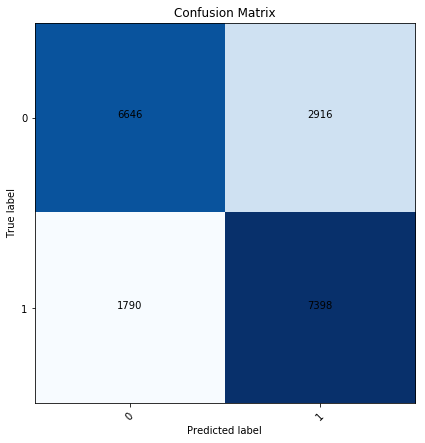

In [137]:
%%time

param_grid = {'max_depth':[4,5,6],                 # The maximum depth of the tree
              'min_samples_leaf':[700,1000,1100]}  # The minimum number of samples required to be at a leaf node

dtree_plus_wild.get_scores(param_grid,skf)
dtree_plus_wild.opt_plots()
dtree_plus_wild.show_conf_matrix()

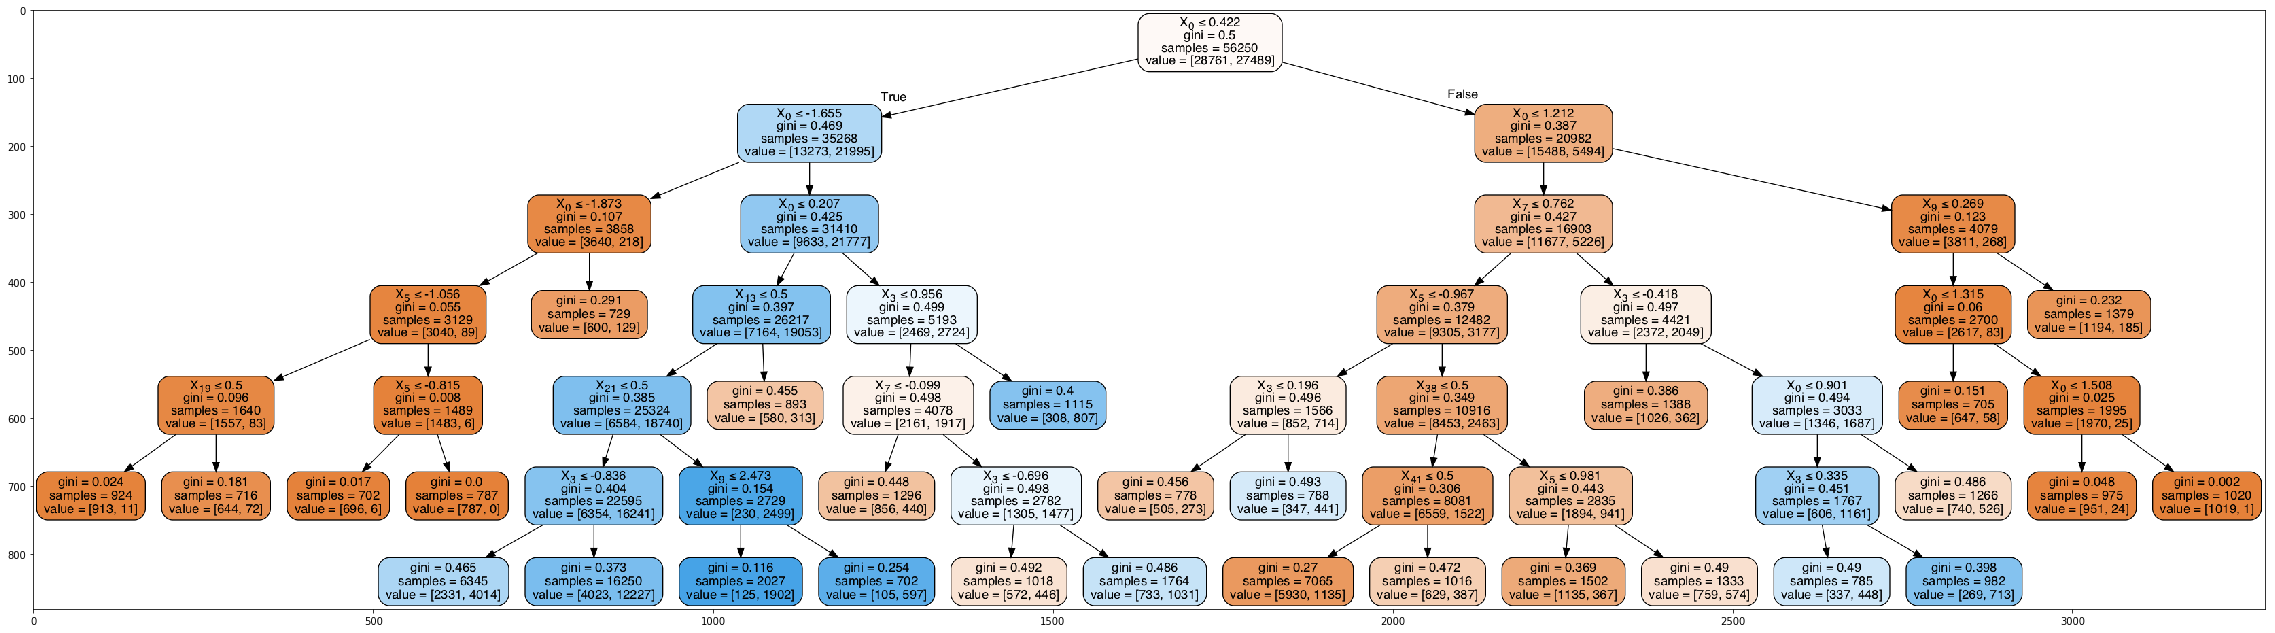

In [134]:
dtree_plus_wild.plot_decision_tree()

In [37]:
dtree = Classification('Decision Tree',X_train,X_val,y_train,y_val)

,Model Name,Train AUC,Validation AUC,Train R^2,Validation R^2
0,Decision Tree,0.813368,0.811141,0.75312,0.749013


The best hyperparameters are:  {'max_depth': 6, 'min_samples_leaf': 700} 



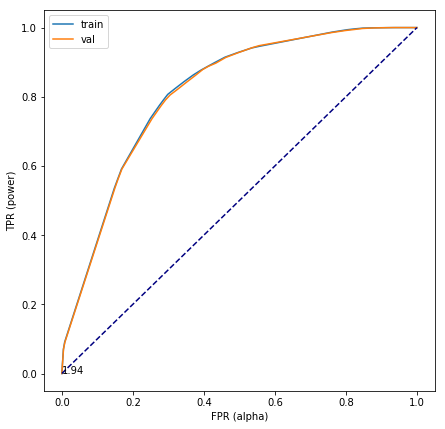

CPU times: user 3.01 s, sys: 206 ms, total: 3.22 s
Wall time: 9.33 s


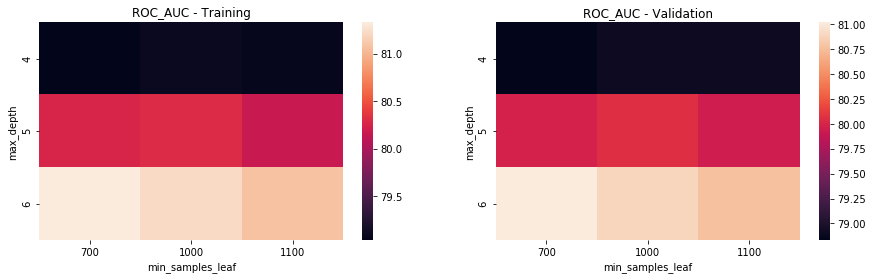

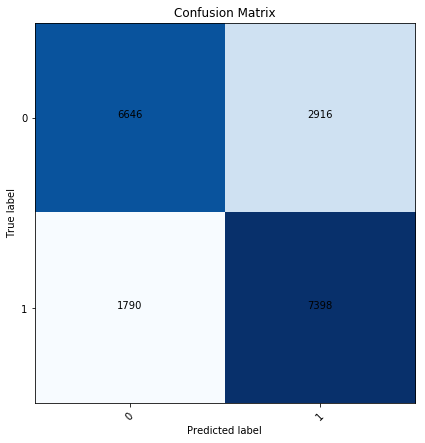

In [38]:
%%time

param_grid = {'max_depth':[4,5,6],                 # The maximum depth of the tree
              'min_samples_leaf':[700,1000,1100]}  # The minimum number of samples required to be at a leaf node

dtree.get_scores(param_grid,skf)
dtree.opt_plots()
dtree.show_conf_matrix()
dtree.plot_decision_tree()

<class 'pydotplus.graphviz.Dot'>
caca


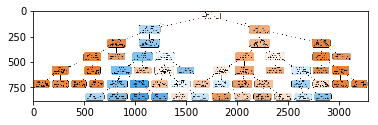

In [107]:
dtree_plus_wild.plot_decision_tree()

### Random Forest

In [138]:
ran_forest_plus_wild = Classification('Random Forest',X_plus_wild_train,X_plus_wild_val,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.814664,0.811809


The best hyperparameters are:  {'max_depth': 6, 'min_samples_leaf': 400} 



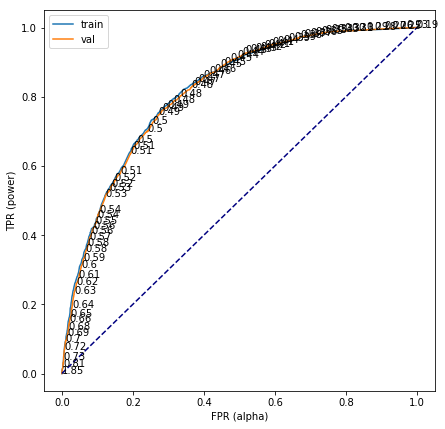

This model does not have a decision tree plot!
CPU times: user 4.39 s, sys: 373 ms, total: 4.77 s
Wall time: 14.1 s


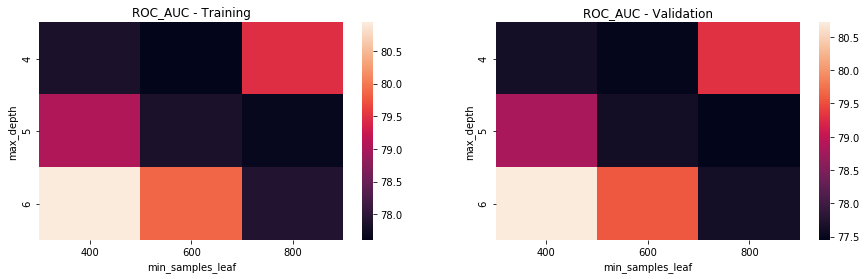

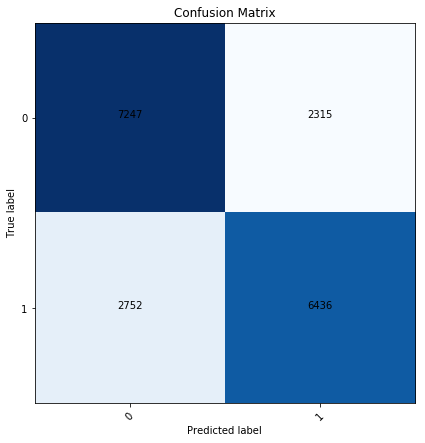

In [139]:
%%time

param_grid = {'max_depth':[4,5,6],                 # The maximum depth of the tree
              'min_samples_leaf':[400,600,800]}  # The minimum number of samples required to be at a leaf node

ran_forest_plus_wild.get_scores(param_grid,skf)
ran_forest_plus_wild.opt_plots()
ran_forest_plus_wild.show_conf_matrix()
ran_forest_plus_wild.plot_decision_tree()

In [140]:
ran_forest = Classification('Random Forest',X_train,X_val,y_train,y_val)

,Model Name,Train AUC,Validation AUC
0,Random Forest,0.819303,0.816342


The best hyperparameters are:  {'max_depth': 6, 'min_samples_leaf': 400} 



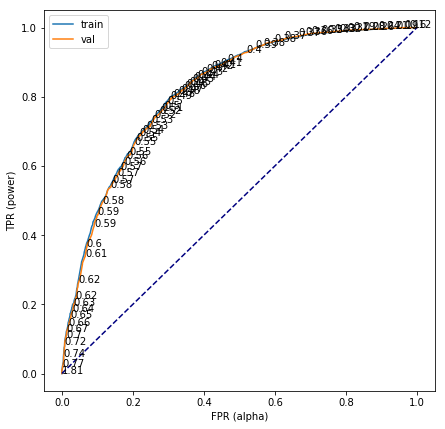

This model does not have a decision tree plot!
CPU times: user 4.87 s, sys: 531 ms, total: 5.4 s
Wall time: 21.2 s


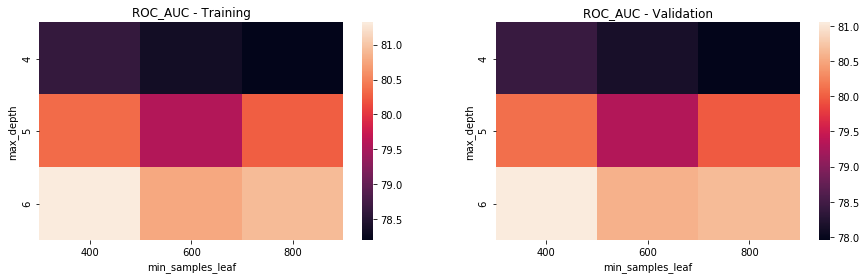

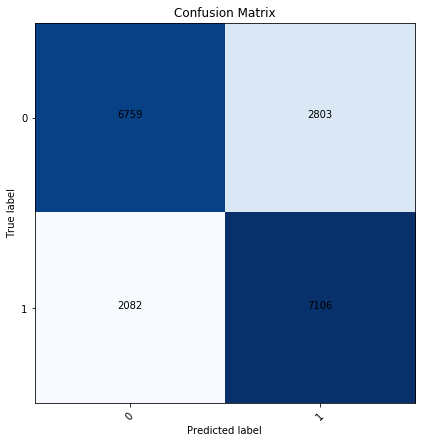

In [141]:
%%time

param_grid = {'max_depth':[4,5,6],                 # The maximum depth of the tree
              'min_samples_leaf':[400,600,800]}  # The minimum number of samples required to be at a leaf node

ran_forest.get_scores(param_grid,skf)
ran_forest.opt_plots()
ran_forest.show_conf_matrix()
ran_forest.plot_decision_tree()